# INTERPRETABILIDAD

<ul>
<li> Autores: Pablo Carretero Collado y Ramón Guerrero Morales</li>
<li> Fecha: 16/12/2021</li>
<li> Email: pablo.carretero@cunef.edu y ramon.guerrero@cunef.edu</li>
<li> Centro: CUNEF Universidad</li>    
</ul>

## Librerias

In [1]:
import shap
# load JS visualization code to notebook
shap.initjs()
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
import numpy as np

## Importación de datos

Importamos los datos necesarios para proceder con su interpretabilidad.

Se importan :


   <li>  collision_xtest_l: datos del xtest procesados mediante lasso.</li>
   <li>  collision_xtrain_l: datos del xtrain procesados mediante lasso.</li>
   <li>  collision_ytest: datos del ytest transformados en el eda. </li>
   <li>  collision_ytrain: datos del ytrain transformados en el eda.</li>

In [2]:
collision_xtest_l= pd.read_csv('collision_xtest_l.csv')
collision_xtrain_l= pd.read_csv('collision_xtrain_l.csv')
collision_ytest= pd.read_csv("collision_ytest_SMOTE.csv")
collision_xtest= pd.read_csv("collision_xtest_SMOTE.csv")

## Cargamos el modelo

Cargamos el mejor modelo con hiperparámetros, el random forest.

In [3]:
filename_rf_hiper = 'finalized_rf_hiper.sav'
CV = pickle.load(open(filename_rf_hiper, 'rb'))

## SHAP

Para la interpretabilidad haremos uso de la api SHAP.

Esta api se utiliza para interpretar los resultados de los modelos de machine learning desde una perspectiva global y desde otra local. 


   <li> Interpretabilidad global: los valores SHAP, es su conjunto, pueden mostrar cuánto contribuye cada predictor, ya sea positiva o negativamente, a la variable objetivo. Es como el gráfico de importancia de la variable, pero puede mostrar la relación  positiva o negativa de cada variable con el objetivo.</li>
   <li>Interpretabilidad local: cada observación obtiene su propio conjunto de valores SHAP. Podemos explicar por qué un caso recibe su predicción y las contribuciones de los predictores y además la interpretabilidad local nos permite identificar y contrastar los impactos de los factores.</li>

In [4]:
explainer = shap.TreeExplainer(CV.best_estimator_)
shap_values = explainer.shap_values(collision_xtest_l)

### Interpretabilidad Global

Mediante un summary_plot de shap, obtendremos la importacia de las variables sobre la variable objetivo, es decir, obtendremos una enumeración descendente de las variables más significativas.  
Las variables superiores tendrán un mayor peso predictivo de la variable objetivo ya que contribuyen más al modelo.

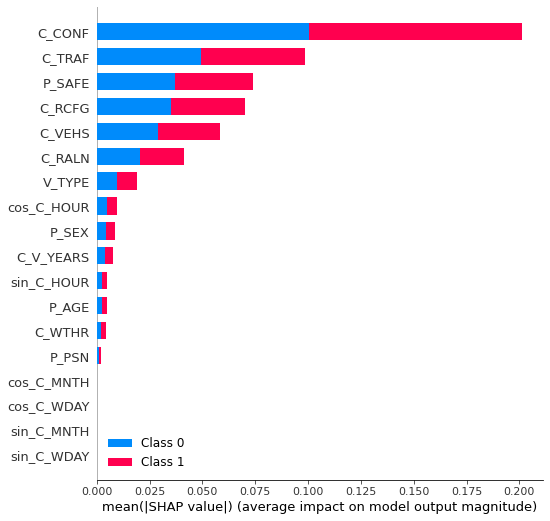

In [7]:
shap.summary_plot(shap_values, collision_xtest_l, plot_type="bar")

La variable que más peso y por lo tanto tendrá un mayor valor predictivo es la configuración de la colisión (C_CONF) la cual tiene categorías como chocar con un objeto en movimiento o en estático.  
Es lógico pensar que el tipo de colisión influye en la severidad de los daños por el accidente ya que no es lo mismo una colisión frontal que una colisión lateral en la parte del conductor debido a que el coche esta preparado para deformaciones frontales pero no laterales. Cuanto más peso tiene esta variable más cerca estará la variable objetivo del fallecimiento que del no fallecimiento.

Siguiendo el orden, la segunda variable con más peso es la señalización vial que hay en la carretera (C_TRAF). Podemos estar de acuerdo en que podrian producirse más accidentes en una carretera sin ningún tipo de señalización que en una donde hay señal de reducción de la velocidad.

Por otro lado, las variables que menos peso tienen en la predicción de nuestra variable objetivo son la antigüedad del vehículo (C_V_YEARS), la edad del individuo (P_AGE) o por ejemplo la posición del individuo afectado (P_PSN).

Por tanto la conclusión que extraemos es que influyen más las variables referidas a elementos del tipo de colisión, señalización de las vías, elementos de seguridad y el tipo de via donde se produce el accidente que por el tipo de vehículo o el género del individuo afectado. Además cuanto mas contribuyan las variables con mas peso más fallecimientos habrá.

La gráfica de valor SHAP muestra además las relaciones positivas y negativas de los predictores con la variable objetivo.

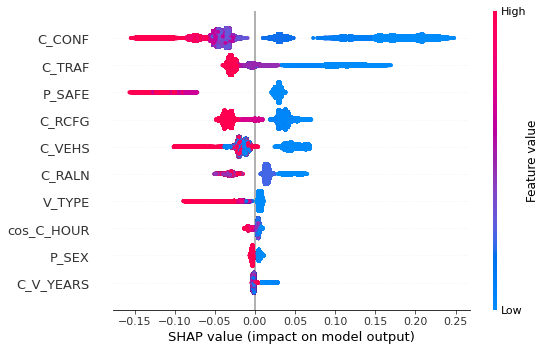

In [8]:
shap.summary_plot(shap_values[0], features=collision_xtest_l, max_display=10)

Observamos como un valor alto de la variable C_CONF afectará de manera negativa a la variable objetivo al igual que pasará con los elementos de seguridad (P_SAFE). Otro dato importante es que al contrario de P_SAFE, la configuración de la colisión con un valor bajo tendrá un impacto positivo en la severidad de la colisión.

Hay variables como el género del individuo que aun que el valor sea alto o bajo impactará de la misma forma en la variable objetivo, por tanto no hay dependencia entre la severidad y que el individuo sea hombre o mujer.

### Interpretabilidad Local

El shap.force_plot () anterior toma tres valores: el valor base, los valores SHAP y la matriz de valores de características. El valor base o el valor esperado es el promedio de la salida del modelo.

In [5]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], collision_xtest_l.iloc[0,:])

Tres variables (C_RALN, P_SAFE, C_RCFG) empujan hacia arriba la predicción ya que estas tienen un valor menor al promedio y afectan de una manera negativa a la variable objetivo. Por tanto, si estas variables tuvieran un valor mayor al promedio contribuirían de manera negativa a la predicción.  
Dos variables (C_CONF, C_VEHS) se comportan al contrario que las anteriores variables. Estas dos empujan hacia abajo la predicción porque un valor menor al promedio está empujando a la predicción. Si estos valores fueran superiores a su media contribuiríann de forma positiva a la predicción.  
Por último, C_TRAF tiene un impacto negativo en la predicción empujandola hacia arriba por la misma razón que las primeras variables que hemos comentado.

En conclusión, como hemos visto en anteriores gráficos de interpretabilidad global, la variable C_CONF tiene mucho peso en la predicción que hemos realizado y un peso más grande en esta ayudará a la predicción.

In [6]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:1000,:], collision_xtest_l.iloc[:1000,:])

En el gráfico anterior podemos interactuar con el impacto de las diferentes variables sobre la objetivo. 

Además, se puede observar perfectamente lo que hemos explicado anteriormente: las variables que afectan de una manera negativa y mandan la predicción hacia arriba (rojo) y las variables que afectan de una manera positiva a la predicciónn y la llevan hacia abajo (azul).